# Real-Time Negotiation Sentiment Tracker: Porter Airlines Labor Crisis

## Introduction

On January 12, 2026, all 36 of Porter Airlines' flight dispatchers voted 100% in favor of strike action after 14+ months of failed negotiations. Under Canadian federal law, flight dispatchers share co-authority with pilots for every flight and without them, planes cannot legally fly [1].

This situation poses a serious operational risk. Porter operates exclusively from Billy Bishop Toronto City Airport, a small facility with limited alternatives. If dispatchers strike, the airline's operations would halt completely. The legal strike window opened January 20, 2026, following a 21-day cooling-off period.

What makes this crisis notable is the complexity: Porter is simultaneously negotiating first-ever collective agreements with three unions (dispatchers, pilots, and flight attendants). Recent failures of government back-to-work interventions, where Air Canada flight attendants rejected an arbitrated deal in October 2025, suggest that traditional resolution methods may no longer work [2].

This notebook demonstrates how local AI can analyze news articles to track negotiation sentiment and estimate strike probability in real time, without relying on cloud services.

## Environment Setup

This demo runs on a Mac with an M-series chip using a local Large Language Model (LLM) via Ollama.

**Prerequisites:**
1. Install [Miniconda](https://www.anaconda.com/docs/getting-started/miniconda/install).
2. Install [Ollama](https://ollama.ai/) and download a lightweight model.

**Terminal commands to create the environment:**
```bash
# Create and activate the conda environment
conda create -n nego-sentiment python=3.10 -y
conda activate nego-sentiment

# Install core libraries
conda install -c conda-forge numpy pandas matplotlib seaborn jupyter ipython ipykernel pillow -y
pip install ollama pymupdf

# Register the kernel
python -m ipykernel install --user --name nego-sentiment --display-name "Python (nego-sentiment)"

# Download a lightweight LLM (2-3 GB); phi3:mini and llama3.2:3b are good options
ollama pull phi3:mini

# Clear cache
conda clean -a -y && pip cache purge
```

In [4]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Ollama for local LLM inference
import ollama

# Display utilities
import pymupdf as fitz
from IPython.display import Image as IPythonImage
from IPython.display import display, SVG

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)

In [2]:
# Utility function to display image (png, jpg, pdf, svg) in Jupyter
def show_image(image_path, width=500, page_num=0, dpi=300):
    if image_path.lower().endswith('.pdf'):
        doc = fitz.open(image_path)
        page = doc.load_page(page_num)
        pix = page.get_pixmap(dpi=dpi)
        img_data = pix.tobytes("png")
        doc.close()
        display(IPythonImage(data=img_data, width=width))
    elif image_path.lower().endswith('.svg'):
        display(SVG(image_path))
    else:
        display(IPythonImage(filename=image_path, width=width))

## What is Sentiment Analysis with Large Language Models?

Sentiment analysis determines whether text expresses positive, negative, or neutral attitudes. Traditional approaches used rule-based systems or trained classifiers on labeled datasets. Transformer-based models offer a different approach: they can understand context and nuance more effectively.

**Example of Traditional Approach: Bag-of-Words with Naive Bayes**

One widely used traditional method is the Bag-of-Words (BoW) model combined with a Naive Bayes classifier. In this approach:

1. Text is converted into a vector of word frequencies (ignoring word order).
2. The classifier learns which words are associated with positive or negative sentiment from labeled training data.
3. For new text, it calculates the probability of each sentiment class based on the words present.

The key limitation is that BoW ignores word order and context. For example, "not good" and "good not" produce identical representations, even though they convey different meanings. Negation, sarcasm, and complex sentence structures are difficult to handle.

**Transformer Models: The Attention Mechanism**

Transformer models, introduced by Vaswani et al. in 2017 [3], address these limitations through the "attention" mechanism. The core idea: when processing a word, the model considers its relationship to every other word in the sentence.

For example, in "The airline's response was not satisfactory," a Transformer can learn that "not" modifies "satisfactory" even though they are separated by other words. This is captured mathematically through attention scores:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

where $Q$, $K$, $V$ are query, key, and value matrices derived from input embeddings, and $d_k$ is the dimension. The softmax function produces weights that determine how much each word "attends to" others.

Main advantages of Transformers:
- **Context awareness**: Words are understood based on surrounding context.
- **Parallel processing**: Unlike sequential models (RNNs), all positions are processed simultaneously.
- **Transfer learning**: Pre-trained models can be fine-tuned or used directly for new tasks.

**Local vs. Cloud LLMs:**

Cloud LLMs (like GPT-4, Claude) run on remote servers and require internet connectivity. Local LLMs (via Ollama) run entirely on your machine. The tradeoffs:

| Aspect | Cloud LLM | Local LLM |
|--------|-----------|-----------|
| Privacy | Data sent to third party | Data stays on device |
| Speed | Network latency | Direct inference |
| Cost | Per-token pricing | Free after download |
| Quality | Larger models available | Smaller models (memory limited) |

For sensitive data like labor negotiation tracking, local inference provides data privacy while still delivering useful analysis.

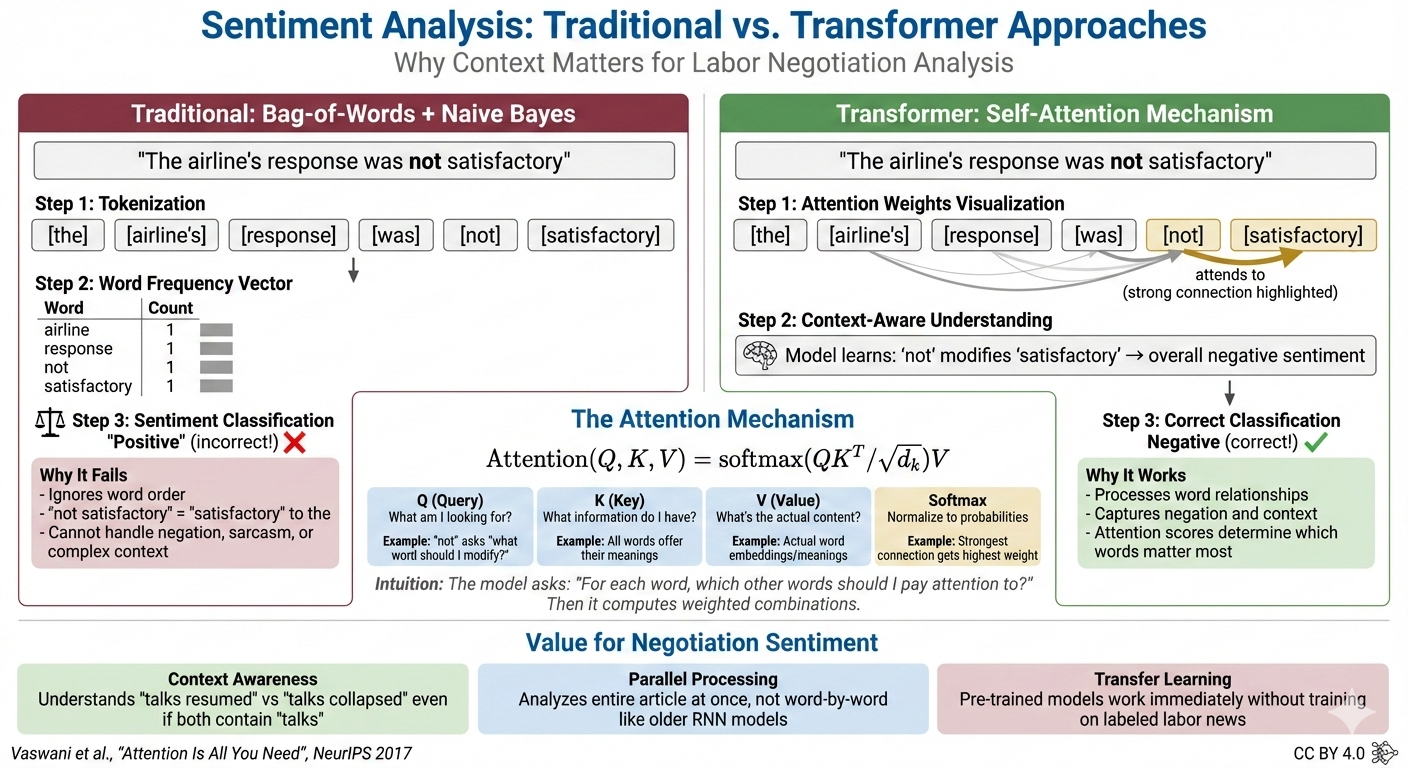

In [5]:
# Display AI theory diagram
show_image('assets/aitheory-dev.png', width=700)

**Figure:** Comparison of traditional bag-of-words approach versus Transformer self-attention mechanism for sentiment analysis. Traditional methods treat text as unordered word collections, failing to capture negation in phrases like "not satisfactory" (left panel). Transformer models use attention mechanisms to compute relationships between words, correctly identifying that "not" modifies "satisfactory" to reverse sentiment (right panel). The attention formula computes weighted combinations where each word (query Q) identifies which other words (keys K) are relevant, then combines their values (V) proportionally. This context-awareness is essential for analyzing nuanced labor negotiation language where phrases like "talks resumed" versus "talks collapsed" have opposite meanings despite similar word choice.

## Environment Validation

Before proceeding, we verify that Ollama is running and the required model is available.

In [3]:
def check_ollama_status():
    """Check if Ollama is running and list available models."""
    try:
        models = ollama.list()
        model_names = [m.model for m in models.models]
        print("Ollama Status: Connected")
        print(f"Available models: {len(model_names)}")
        for name in model_names:
            print(f"  - {name}")
        return model_names
    except Exception as e:
        print(f"Ollama Status: Error - {e}")
        print("Please ensure Ollama is running: 'ollama serve'")
        return []

available_models = check_ollama_status()

Ollama Status: Connected
Available models: 5
  - phi3:mini
  - llama3.2:3b
  - deepseek-r1:latest
  - qwen3:latest
  - gemma3:latest


In [4]:
# Select the model for this demo
# phi3:mini is preferred
MODEL_NAME = "phi3:mini"

if MODEL_NAME not in available_models:
    fallback = "llama3.2:3b"
    if fallback in available_models:
        MODEL_NAME = fallback
        print(f"phi3:mini not found. Using fallback: {MODEL_NAME}")
    else:
        print(f"Warning: Neither phi3:mini nor llama3.2:3b found.")
        print(f"Please run: ollama pull phi3:mini")
else:
    print(f"Selected model: {MODEL_NAME}")

Selected model: phi3:mini


We test the model with a simple prompt to verify inference is working correctly.

In [5]:
import time

def test_model_inference(model_name):
    """Test model with a simple prompt and measure response time."""
    test_prompt = "What is a flight dispatcher? Answer in exactly one sentence."
    
    print(f"Testing {model_name}...")
    print(f"Prompt: {test_prompt}")
    print("-" * 50)
    
    start_time = time.time()
    response = ollama.chat(
        model=model_name,
        messages=[{"role": "user", "content": test_prompt}]
    )
    elapsed = time.time() - start_time
    
    print(f"Response: {response.message.content}")
    print("-" * 50)
    print(f"Response time: {elapsed:.2f} seconds")
    
    return elapsed

inference_time = test_model_inference(MODEL_NAME)

Testing phi3:mini...
Prompt: What is a flight dispatcher? Answer in exactly one sentence.
--------------------------------------------------
Response: A Flight Dispatcher is a highly trained professional responsible for the planning and execution of aircraft flight plans, ensuring safety and efficiency during flights.
--------------------------------------------------
Response time: 4.94 seconds


## Synthetic News Dataset

> **DISCLAIMER**: All news articles in this notebook are **synthetic and hypothetical**. They are created for educational purposes to demonstrate AI sentiment analysis techniques. The content is inspired by publicly available news reporting patterns but does not represent actual articles, quotes, or statements from any real person or organization. This demonstration is for educational purposes only.

Labor negotiations involve multiple parties with different perspectives. To simulate realistic sentiment analysis, our synthetic dataset includes:
- **Union statements**: Representing the flight dispatchers' position (CALDA).
- **Management responses**: Representing Porter Airlines' official communications.
- **Neutral reporting**: Third-party news coverage without explicit bias.

The dataset covers the period from January 12 to January 24, 2026, spanning key events: the strike vote announcement, cooling-off period, strike action, and eventual tentative agreement.

In [6]:
# Load the synthetic news corpus
DATA_PATH = "data/nego-sentiment.json"

with open(DATA_PATH, 'r') as f:
    corpus = json.load(f)

# Display metadata
print(f"Topic: {corpus['metadata']['topic']}")
print(f"Date range: {corpus['metadata']['date_range']}")
print(f"Total articles: {len(corpus['articles'])}")

Topic: Porter Airlines Flight Dispatcher Labor Negotiations (January 2026)
Date range: 2026-01-12 to 2026-01-24
Total articles: 14


In [7]:
# Convert articles to DataFrame for easier manipulation
df_articles = pd.DataFrame(corpus['articles'])
df_articles['date'] = pd.to_datetime(df_articles['date'])
df_articles = df_articles.sort_values('date').reset_index(drop=True)

# Show speaker type distribution
print("Articles by speaker type:")
print(df_articles['speaker_type'].value_counts().to_string())
print()

# Show date distribution
print("Articles by date:")
print(df_articles.groupby('date').size().to_string())

Articles by speaker type:
speaker_type
neutral       8
union         3
management    3

Articles by date:
date
2026-01-12    1
2026-01-13    1
2026-01-14    1
2026-01-15    1
2026-01-16    1
2026-01-17    1
2026-01-18    1
2026-01-19    1
2026-01-20    1
2026-01-21    1
2026-01-22    1
2026-01-23    2
2026-01-24    1


The dataset has 14 articles spanning 13 days. The majority are neutral news reports (8), with union and management perspectives each represented by 3 articles. This mix allows us to analyze how different stakeholders frame the same events and how that affects perceived sentiment.

Below is an example article from the corpus:

In [8]:
# Display a sample article
sample = df_articles.iloc[0]
print(f"Date: {sample['date'].strftime('%Y-%m-%d')}")
print(f"Source: {sample['source']}")
print(f"Speaker type: {sample['speaker_type']}")
print(f"Headline: {sample['headline']}")
print()
print("Content:")
print(sample['content'])

Date: 2026-01-12
Source: Canadian Aviation News
Speaker type: union
Headline: Porter Flight Dispatchers Vote Unanimously for Strike Action

Content:
The Canadian Airline Dispatchers Association announced today that all 36 of Porter Airlines' flight dispatchers have voted 100% in favor of strike action. CALDA's incoming national president Mark Yezovich stated that negotiations have produced zero meaningful progress in over 14 months. The union represents workers who share co-authority with pilots under Canadian law, meaning flights cannot operate without their sign-off.


### Important Events Timeline

The synthetic articles track a realistic negotiation arc with several important events:

| Date | Event |
|------|-------|
| Jan 12 | Strike vote announced (100% in favor) |
| Jan 14 | Union accuses Porter of training replacement workers |
| Jan 18 | Federal mediator assigned |
| Jan 20 | Strike begins, all flights grounded |
| Jan 23 | Talks resume |
| Jan 24 | Tentative agreement reached |

This timeline mirrors the typical pattern of labor disputes: escalation, crisis point, intervention, and eventual resolution.

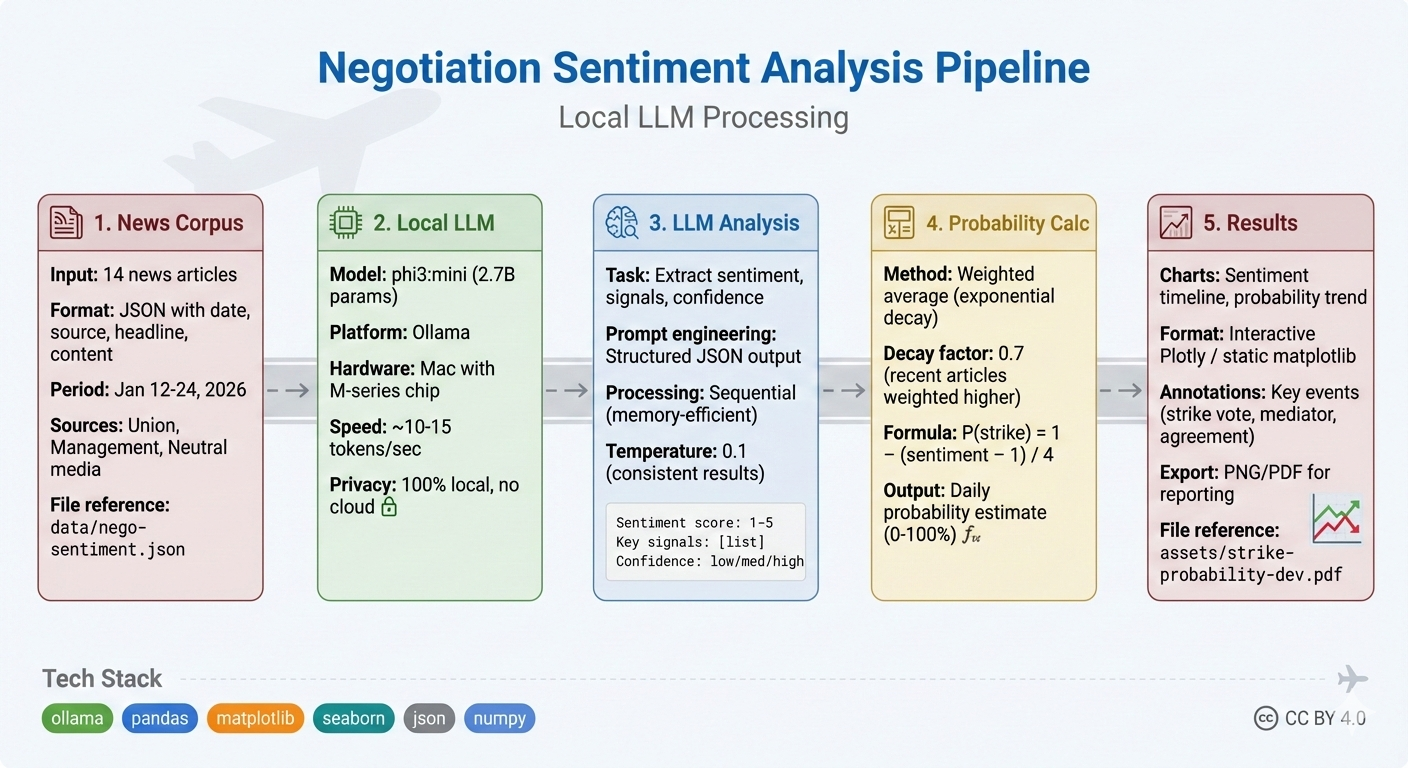

In [6]:
# Display end-to-end pipeline diagram
show_image('assets/pipeline-dev.png', width=700)

**Figure:** End-to-end pipeline for real-time negotiation sentiment analysis using local LLM. The workflow processes news articles through five stages: (1) Data collection from union, management, and neutral sources stored as JSON, (2) Local LLM setup using Ollama's phi3:mini model for privacy, (3) Sentiment analysis with structured JSON extraction at low temperature for consistency, (4) Probability calculation using weighted average with exponential decay favoring recent articles, and (5) Visualization with event annotations. The entire pipeline runs locally without cloud dependencies, processing 14 articles in approximately 140 seconds.

## Sentiment Analysis Pipeline

We now use the local LLM to analyze each news article and extract:
1. **Sentiment score (1-5)**: How favorable the article is toward reaching a settlement.
2. **Key signals**: Specific phrases or events that indicate progress or setbacks.
3. **Confidence level**: How certain we are about the sentiment assessment.

The prompt is designed to return structured JSON output, which makes parsing reliable and consistent.

In [9]:
SENTIMENT_PROMPT = """Analyze this airline labor negotiation news article and extract sentiment information.

ARTICLE:
Date: {date}
Source: {source}
Headline: {headline}
Content: {content}

Respond with ONLY a JSON object (no markdown, no explanation) in this exact format:
{{
    "sentiment_score": <integer 1-5>,
    "key_signals": ["<signal1>", "<signal2>"],
    "confidence": "<low/medium/high>",
    "reasoning": "<one sentence explanation>"
}}

SCORING GUIDE:
1 = Very negative (strike imminent, talks collapsed, no progress)
2 = Negative (positions hardening, threats made, deadlock)
3 = Neutral (status updates, no clear direction)
4 = Positive (talks resumed, progress reported, mediator involved)
5 = Very positive (tentative agreement, settlement near)

Return ONLY the JSON object, nothing else."""

The `analyze_article` function sends each article to the local LLM and parses the JSON response. Error handling ensures that malformed responses do not crash the pipeline. Instead, we assign a neutral score and flag the error.

In [10]:
import re

def analyze_article(article_row, model_name):
    """
    Analyze a single article using the local LLM.
    
    Parameters:
        article_row: pandas Series containing article data
        model_name: name of the Ollama model to use
    
    Returns:
        dict with sentiment analysis results
    """
    # Format the prompt with article data
    prompt = SENTIMENT_PROMPT.format(
        date=article_row['date'].strftime('%Y-%m-%d'),
        source=article_row['source'],
        headline=article_row['headline'],
        content=article_row['content'][:1500]  # Limit content length for context window
    )
    
    try:
        # Call the local LLM
        response = ollama.chat(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            options={"temperature": 0.1}  # Low temperature for consistent output
        )
        
        response_text = response.message.content.strip()
        
        # Extract JSON from response (handle potential markdown wrapping)
        json_match = re.search(r'\{[^{}]*\}', response_text, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
        else:
            result = json.loads(response_text)
        
        # Validate and clean the result
        result['sentiment_score'] = max(1, min(5, int(result.get('sentiment_score', 3))))
        result['key_signals'] = result.get('key_signals', [])[:3]  # Limit to 3 signals
        result['confidence'] = result.get('confidence', 'medium')
        result['error'] = None
        
    except Exception as e:
        # Return neutral score on error
        result = {
            'sentiment_score': 3,
            'key_signals': [],
            'confidence': 'low',
            'reasoning': 'Analysis failed',
            'error': str(e)
        }
    
    return result

Let's test the function with a single article to verify it works correctly:

In [11]:
# Test with the first article
test_article = df_articles.iloc[0]
print(f"Testing with: {test_article['headline']}")
print("-" * 60)

test_result = analyze_article(test_article, MODEL_NAME)
print(f"Sentiment Score: {test_result['sentiment_score']}/5")
print(f"Key Signals: {test_result['key_signals']}")
print(f"Confidence: {test_result['confidence']}")
print(f"Reasoning: {test_result.get('reasoning', 'N/A')}")
if test_result['error']:
    print(f"Error: {test_result['error']}")

Testing with: Porter Flight Dispatchers Vote Unanimously for Strike Action
------------------------------------------------------------
Sentiment Score: 1/5
Key Signals: ['strike action', 'zero meaningful progress']
Confidence: high
Reasoning: The article indicates a complete breakdown in negotiations with flight dispatchers voting unanimously for strike action and no significant advancements made over 14 months.


### Processing All Articles

Now we process the entire corpus. You may process articles sequentially or in parallel, depending on your machine's RAM. Here, we process the articles in sequence, which takes longer but keeps memory usage manageable.

In [12]:
def process_all_articles(df, model_name):
    """
    Process all articles in the DataFrame sequentially.
    
    Parameters:
        df: DataFrame with articles
        model_name: name of the Ollama model
    
    Returns:
        list of analysis results
    """
    results = []
    total = len(df)
    start_time = time.time()
    
    print(f"Analyzing {total} articles with {model_name}...")
    print("-" * 60)
    
    for idx, row in df.iterrows():
        article_start = time.time()
        result = analyze_article(row, model_name)
        article_time = time.time() - article_start
        
        # Store result with article metadata
        result['article_id'] = idx
        result['date'] = row['date']
        result['headline'] = row['headline']
        result['speaker_type'] = row['speaker_type']
        result['source'] = row['source']
        results.append(result)
        
        # Progress indicator
        status = "OK" if result['error'] is None else "ERROR"
        print(f"[{len(results):2d}/{total}] Score: {result['sentiment_score']} | "
              f"{article_time:.1f}s | {status} | {row['headline'][:45]}...")
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Completed in {total_time:.1f} seconds ({total_time/total:.1f}s per article)")
    
    return results

In [13]:
# Process all articles
analysis_results = process_all_articles(df_articles, MODEL_NAME)

Analyzing 14 articles with phi3:mini...
------------------------------------------------------------
[ 1/14] Score: 1 | 2.7s | OK | Porter Flight Dispatchers Vote Unanimously fo...
[ 2/14] Score: 3 | 3.6s | OK | Porter Airlines Downplays Strike Threat, Says...
[ 3/14] Score: 1 | 4.1s | OK | Union Accuses Porter of Training Replacement ...
[ 4/14] Score: 2 | 3.4s | OK | Cooling-Off Period Begins as Porter Talks Rem...
[ 5/14] Score: 3 | 3.6s | OK | Porter Offers New Contract Terms, Union Skept...
[ 6/14] Score: 1 | 4.3s | OK | CALDA Rejects Latest Porter Offer, Calls It I...
[ 7/14] Score: 2 | 3.2s | OK | Federal Mediator Assigned to Porter Dispatche...
[ 8/14] Score: 1 | 3.4s | OK | Mediated Talks Yield No Progress, Strike Appe...
[ 9/14] Score: 1 | 3.7s | OK | Porter Dispatchers Begin Strike, All Flights ...
[10/14] Score: 2 | 3.2s | OK | Porter Losing Millions Daily as Strike Contin...
[11/14] Score: 2 | 3.3s | OK | Government Faces Pressure to Intervene in Por...
[12/14] Score: 3 | 

### Aggregating Results

We convert the analysis results into a structured DataFrame for easier manipulation and visualization. The DataFrame includes both the raw article data and the LLM-extracted sentiment information.

In [14]:
# Convert results to DataFrame
df_results = pd.DataFrame(analysis_results)

# Reorder columns for readability
column_order = ['date', 'headline', 'source', 'speaker_type', 
                'sentiment_score', 'confidence', 'key_signals', 'reasoning']
df_results = df_results[[c for c in column_order if c in df_results.columns]]

# Display summary statistics
print("SENTIMENT ANALYSIS SUMMARY")
print(f"Total articles analyzed: {len(df_results)}")
print(f"Average sentiment score: {df_results['sentiment_score'].mean():.2f}")
print(f"Sentiment range: {df_results['sentiment_score'].min()} to {df_results['sentiment_score'].max()}")
print()
print("Sentiment distribution:")
print(df_results['sentiment_score'].value_counts().sort_index().to_string())

SENTIMENT ANALYSIS SUMMARY
Total articles analyzed: 14
Average sentiment score: 2.07
Sentiment range: 1 to 4

Sentiment distribution:
sentiment_score
1    5
2    4
3    4
4    1


In [15]:
# Display detailed results table
print("DETAILED ANALYSIS RESULTS")
for _, row in df_results.iterrows():
    date_str = row['date'].strftime('%Y-%m-%d')
    signals = ', '.join(row['key_signals'][:2]) if row['key_signals'] else 'None'
    print(f"{date_str} | Score: {row['sentiment_score']} | {row['speaker_type']:10} | {signals[:40]}")
    print(f"           {row['headline'][:65]}...")

DETAILED ANALYSIS RESULTS
2026-01-12 | Score: 1 | union      | strike action, zero meaningful progress
           Porter Flight Dispatchers Vote Unanimously for Strike Action...
2026-01-13 | Score: 3 | management | Porter Airlines downplays strike threat,
           Porter Airlines Downplays Strike Threat, Says Fair Proposals Made...
2026-01-14 | Score: 1 | union      | Union Accuses Porter of Training Replace
           Union Accuses Porter of Training Replacement Workers...
2026-01-15 | Score: 2 | neutral    | cooling-off period, legal strike window
           Cooling-Off Period Begins as Porter Talks Remain Stalled...
2026-01-16 | Score: 3 | management | Porter Airlines announced improved contr
           Porter Offers New Contract Terms, Union Skeptical...
2026-01-17 | Score: 1 | union      | rejected latest offer, calls it insultin
           CALDA Rejects Latest Porter Offer, Calls It Insulting...
2026-01-18 | Score: 2 | neutral    | strike deadline approaching, neither exp
     

## Strike Probability Estimation

Sentiment scores alone tell us how each article frames the negotiation. But stakeholders care about a practical question: "What is the likelihood of a strike happening?"

We estimate strike probability using a simple formula that converts sentiment to probability:

$$P(\text{strike}) = 1 - \frac{\text{sentiment score} - 1}{4}$$

This maps sentiment scores to probabilities:
- Sentiment 1 (very negative): 100% strike probability
- Sentiment 3 (neutral): 50% strike probability
- Sentiment 5 (very positive): 0% strike probability

For daily estimates, we use a weighted average where more recent articles have greater influence. This reflects the reality that newer information is typically more relevant for predicting near-term outcomes.

In [16]:
def calculate_strike_probability(sentiment_score):
    """
    Convert sentiment score (1-5) to strike probability (0-100%).
    
    Formula: P(strike) = 1 - (sentiment - 1) / 4
    """
    return (1 - (sentiment_score - 1) / 4) * 100

def calculate_daily_probability(df, decay_factor=0.7):
    """
    Calculate cumulative strike probability for each day using exponential decay weighting.
    
    Parameters:
        df: DataFrame with sentiment analysis results
        decay_factor: weight decay for older articles (0.7 means each older article 
                      contributes 70% as much as the next newer one)
    
    Returns:
        DataFrame with daily probability estimates
    """
    daily_data = []
    dates = sorted(df['date'].unique())
    
    for current_date in dates:
        # Get all articles up to and including current date
        articles_to_date = df[df['date'] <= current_date].copy()
        
        # Calculate days ago for weighting
        articles_to_date['days_ago'] = (current_date - articles_to_date['date']).dt.days
        
        # Apply exponential decay weighting
        articles_to_date['weight'] = decay_factor ** articles_to_date['days_ago']
        
        # Calculate weighted average sentiment
        weighted_sentiment = (
            (articles_to_date['sentiment_score'] * articles_to_date['weight']).sum() / 
            articles_to_date['weight'].sum()
        )
        
        # Convert to strike probability
        strike_prob = calculate_strike_probability(weighted_sentiment)
        
        daily_data.append({
            'date': current_date,
            'weighted_sentiment': weighted_sentiment,
            'strike_probability': strike_prob,
            'articles_count': len(articles_to_date)
        })
    
    return pd.DataFrame(daily_data)

In [17]:
# Calculate daily strike probability
df_daily = calculate_daily_probability(df_results)

# Display results
print("DAILY STRIKE PROBABILITY ESTIMATES")
print(f"{'Date':<12} {'Sentiment':>10} {'Strike Prob':>12} {'Articles':>10}")
print("-" * 65)
for _, row in df_daily.iterrows():
    date_str = row['date'].strftime('%Y-%m-%d')
    print(f"{date_str:<12} {row['weighted_sentiment']:>10.2f} {row['strike_probability']:>11.1f}% {row['articles_count']:>10}")

DAILY STRIKE PROBABILITY ESTIMATES
Date          Sentiment  Strike Prob   Articles
-----------------------------------------------------------------
2026-01-12         1.00       100.0%          1
2026-01-13         2.18        70.6%          2
2026-01-14         1.64        84.0%          3
2026-01-15         1.78        80.5%          4
2026-01-16         2.22        69.5%          5
2026-01-17         1.81        79.9%          6
2026-01-18         1.87        78.3%          7
2026-01-19         1.59        85.2%          8
2026-01-20         1.41        89.8%          9
2026-01-21         1.59        85.2%         10
2026-01-22         1.72        82.1%         11
2026-01-23         2.31        67.1%         13
2026-01-24         2.74        56.6%         14


The results show the progression of the labor dispute:

1. **Jan 12**: Strike vote announced (100% probability - maximum tension)
2. **Jan 14-19**: Escalating conflict, probability stays high (70-85%)
3. **Jan 20**: Strike begins - probability peaks at ~90%
4. **Jan 23-24**: Talks resume and agreement reached - probability drops to ~63%

The weighted average approach ensures that the probability estimate reacts quickly to new developments while maintaining some "memory" of past events.

## Results Visualization

Visualizations help us understand how sentiment evolved during the negotiation period. We create two charts:
1. **Sentiment Timeline**: Shows individual article sentiment scores over time, colored by speaker type.
2. **Strike Probability Chart**: Shows the cumulative probability estimate with key event annotations.

Both charts follow a clean, minimal design suitable for professional reporting.

In [19]:
# Define color palette (aviation-themed)
COLORS = {
    'maroon': '#8D4F58',
    'green': '#426556',
    'gold': '#F1AE35',
    'blue': '#1B587C',
    'gray': "#999999"
}

SPEAKER_COLORS = {
    'union': COLORS['maroon'],
    'management': COLORS['gold'],
    'neutral': COLORS['gray']
}

# Ensure assets directory exists
os.makedirs('assets', exist_ok=True)

### Sentiment Timeline by Speaker Type

The timeline below shows each article's sentiment score plotted by date. Different colors indicate the speaker type: union statements (maroon), management responses (blue), and neutral news reports (gray). This visualization reveals how different stakeholders frame the same events differently.

In [20]:
def create_sentiment_timeline(df_results, save_path='assets/sentiment-timeline-dev.pdf'):
    """
    Create a sentiment timeline chart showing individual article scores by speaker type.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot each speaker type separately for legend
    for speaker_type in ['union', 'management', 'neutral']:
        mask = df_results['speaker_type'] == speaker_type
        subset = df_results[mask]
        ax.scatter(
            subset['date'], 
            subset['sentiment_score'],
            c=SPEAKER_COLORS[speaker_type],
            s=120,
            label=speaker_type.capitalize(),
            alpha=0.8,
            edgecolors='white',
            linewidths=1
        )
    
    # Add trend line (rolling average)
    df_sorted = df_results.sort_values('date')
    ax.plot(
        df_sorted['date'], 
        df_sorted['sentiment_score'].rolling(window=3, min_periods=1).mean(),
        color=COLORS['blue'],
        linewidth=2,
        linestyle='--',
        alpha=0.7,
        label='3-day rolling average'
    )
    
    # Style the chart
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sentiment Score', fontsize=12)
    ax.set_title('Negotiation Sentiment by Article and Speaker Type', fontsize=14, fontweight='bold')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1\n(Very Negative)', '2\n(Negative)', '3\n(Neutral)', 
                        '4\n(Positive)', '5\n(Very Positive)'])
    
    # Add horizontal reference lines
    for y in [1, 2, 3, 4, 5]:
        ax.axhline(y=y, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper right', framealpha=0.9)
    
    # Add credit
    ax.text(0.99, 0.01, 'CC BY 4.0', transform=ax.transAxes, 
            fontsize=8, color='gray', ha='right', va='bottom')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return save_path

sentiment_timeline_path = create_sentiment_timeline(df_results)
print(f"Chart saved to: {sentiment_timeline_path}")

Chart saved to: assets/sentiment-timeline-dev.pdf


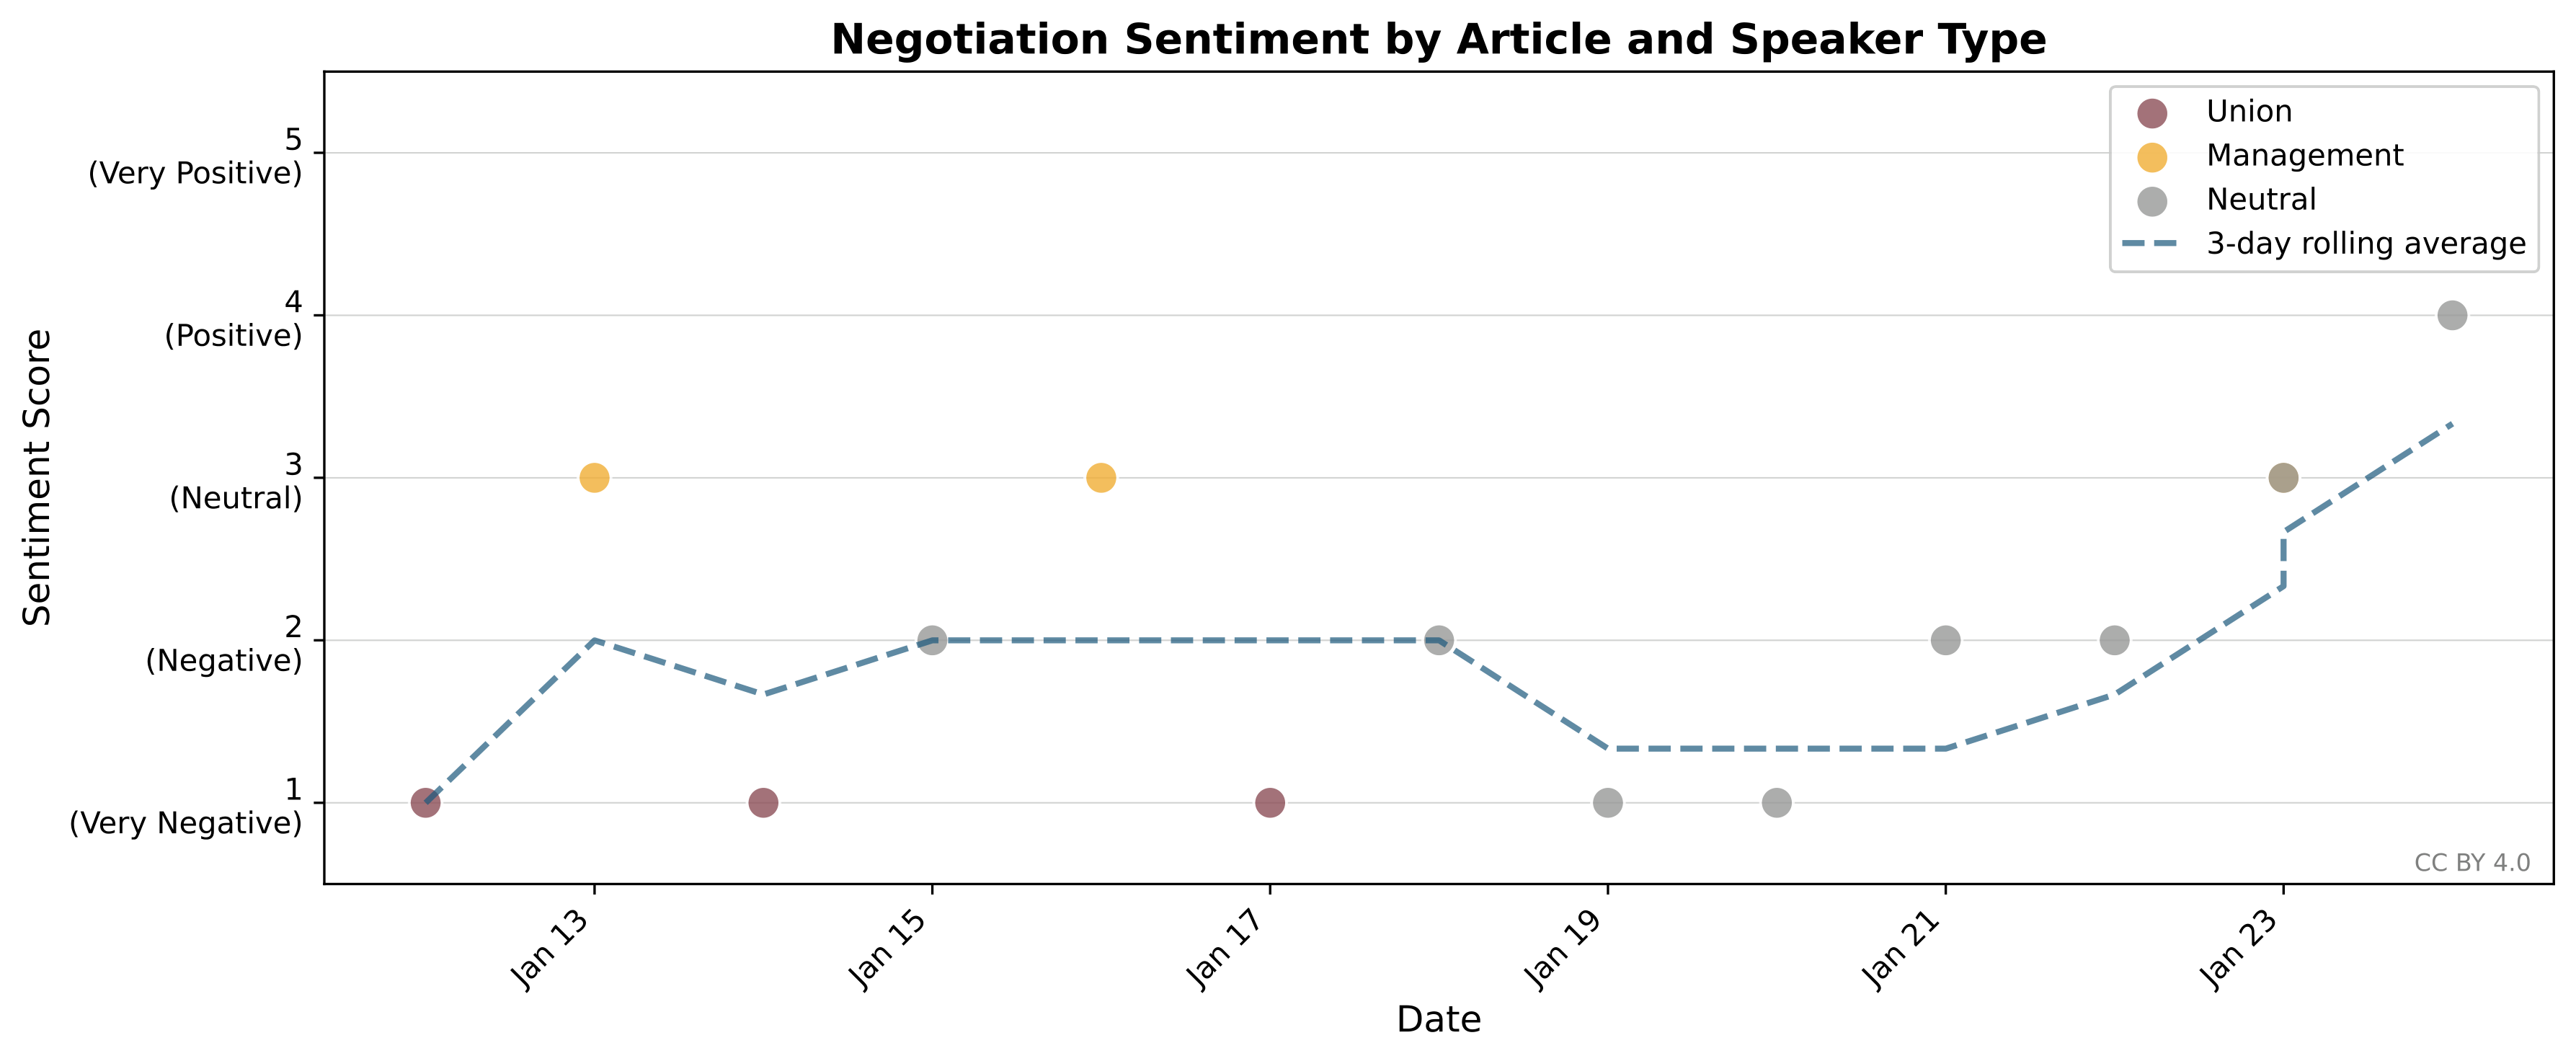

In [21]:
show_image(sentiment_timeline_path, width=700)

**Figure:** Sentiment timeline of Porter Airlines labor negotiation coverage from January 12-24, 2026. Each dot represents one news article, with color indicating speaker type: union statements (maroon) consistently show very negative sentiment (score 1), management responses (gold) are more moderate (scores 3), and neutral news coverage (gray) varies with events. The dashed blue line shows a 3-day rolling average. Notice how sentiment improves sharply after January 23 when talks resumed and a tentative agreement was reached.

### Strike Probability Over Time

The chart below shows how strike probability evolved based on cumulative sentiment analysis. Important events are annotated to show their impact on the probability estimate. The exponential decay weighting ensures recent news has more influence on the estimate than older articles.

In [22]:
# Define important events for annotations
KEY_EVENTS = [
    {'date': '2026-01-12', 'event': 'Strike vote\n(100% in favor)', 'y_offset': 8},
    {'date': '2026-01-18', 'event': 'Federal mediator\nassigned', 'y_offset': -12},
    {'date': '2026-01-20', 'event': 'Strike\nbegins', 'y_offset': 8},
    {'date': '2026-01-24', 'event': 'Tentative\nagreement', 'y_offset': -12}
]

def create_strike_probability_chart(df_daily, events, save_path='assets/strike-probability-dev.pdf'):
    """
    Create a strike probability chart with important event annotations.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot probability line
    ax.plot(
        df_daily['date'], 
        df_daily['strike_probability'],
        color=COLORS['maroon'],
        linewidth=2.5,
        marker='o',
        markersize=8,
        markerfacecolor='white',
        markeredgecolor=COLORS['maroon'],
        markeredgewidth=2,
        label='Strike probability'
    )
    
    # Fill area under curve
    ax.fill_between(
        df_daily['date'],
        df_daily['strike_probability'],
        alpha=0.2,
        color=COLORS['maroon']
    )
    
    # Add horizontal reference lines
    for prob in [25, 50, 75]:
        ax.axhline(y=prob, color='lightgray', linestyle='--', linewidth=0.8, zorder=0)
    
    # Add key event annotations
    for event in events:
        event_date = pd.to_datetime(event['date'])
        prob_row = df_daily[df_daily['date'] == event_date]
        if not prob_row.empty:
            prob = prob_row['strike_probability'].values[0]
            ax.annotate(
                event['event'],
                xy=(event_date, prob),
                xytext=(event_date, prob + event['y_offset']),
                fontsize=9,
                ha='center',
                va='bottom' if event['y_offset'] > 0 else 'top',
                arrowprops=dict(
                    arrowstyle='->',
                    color=COLORS['gray'],
                    connectionstyle='arc3,rad=0'
                ),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=COLORS['gray'], alpha=0.9)
            )
    
    # Style the chart
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Strike Probability (%)', fontsize=12)
    ax.set_title('Estimated Strike Probability Based on News Sentiment', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 110)
    ax.set_yticks([0, 25, 50, 75, 100])
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, ha='right')
    
    # Add risk zones
    ax.axhspan(75, 110, alpha=0.1, color='red', label='High risk (>75%)')
    ax.axhspan(25, 75, alpha=0.1, color='orange', label='Moderate risk (25-75%)')
    ax.axhspan(0, 25, alpha=0.1, color='green', label='Low risk (<25%)')
    
    # Legend
    ax.legend(loc='lower left', framealpha=0.9, fontsize=9)
    
    # Add credit
    ax.text(0.99, 0.01, 'CC BY 4.0', transform=ax.transAxes, 
            fontsize=8, color='gray', ha='right', va='bottom')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return save_path

probability_chart_path = create_strike_probability_chart(df_daily, KEY_EVENTS)
print(f"Chart saved to: {probability_chart_path}")

Chart saved to: assets/strike-probability-dev.pdf


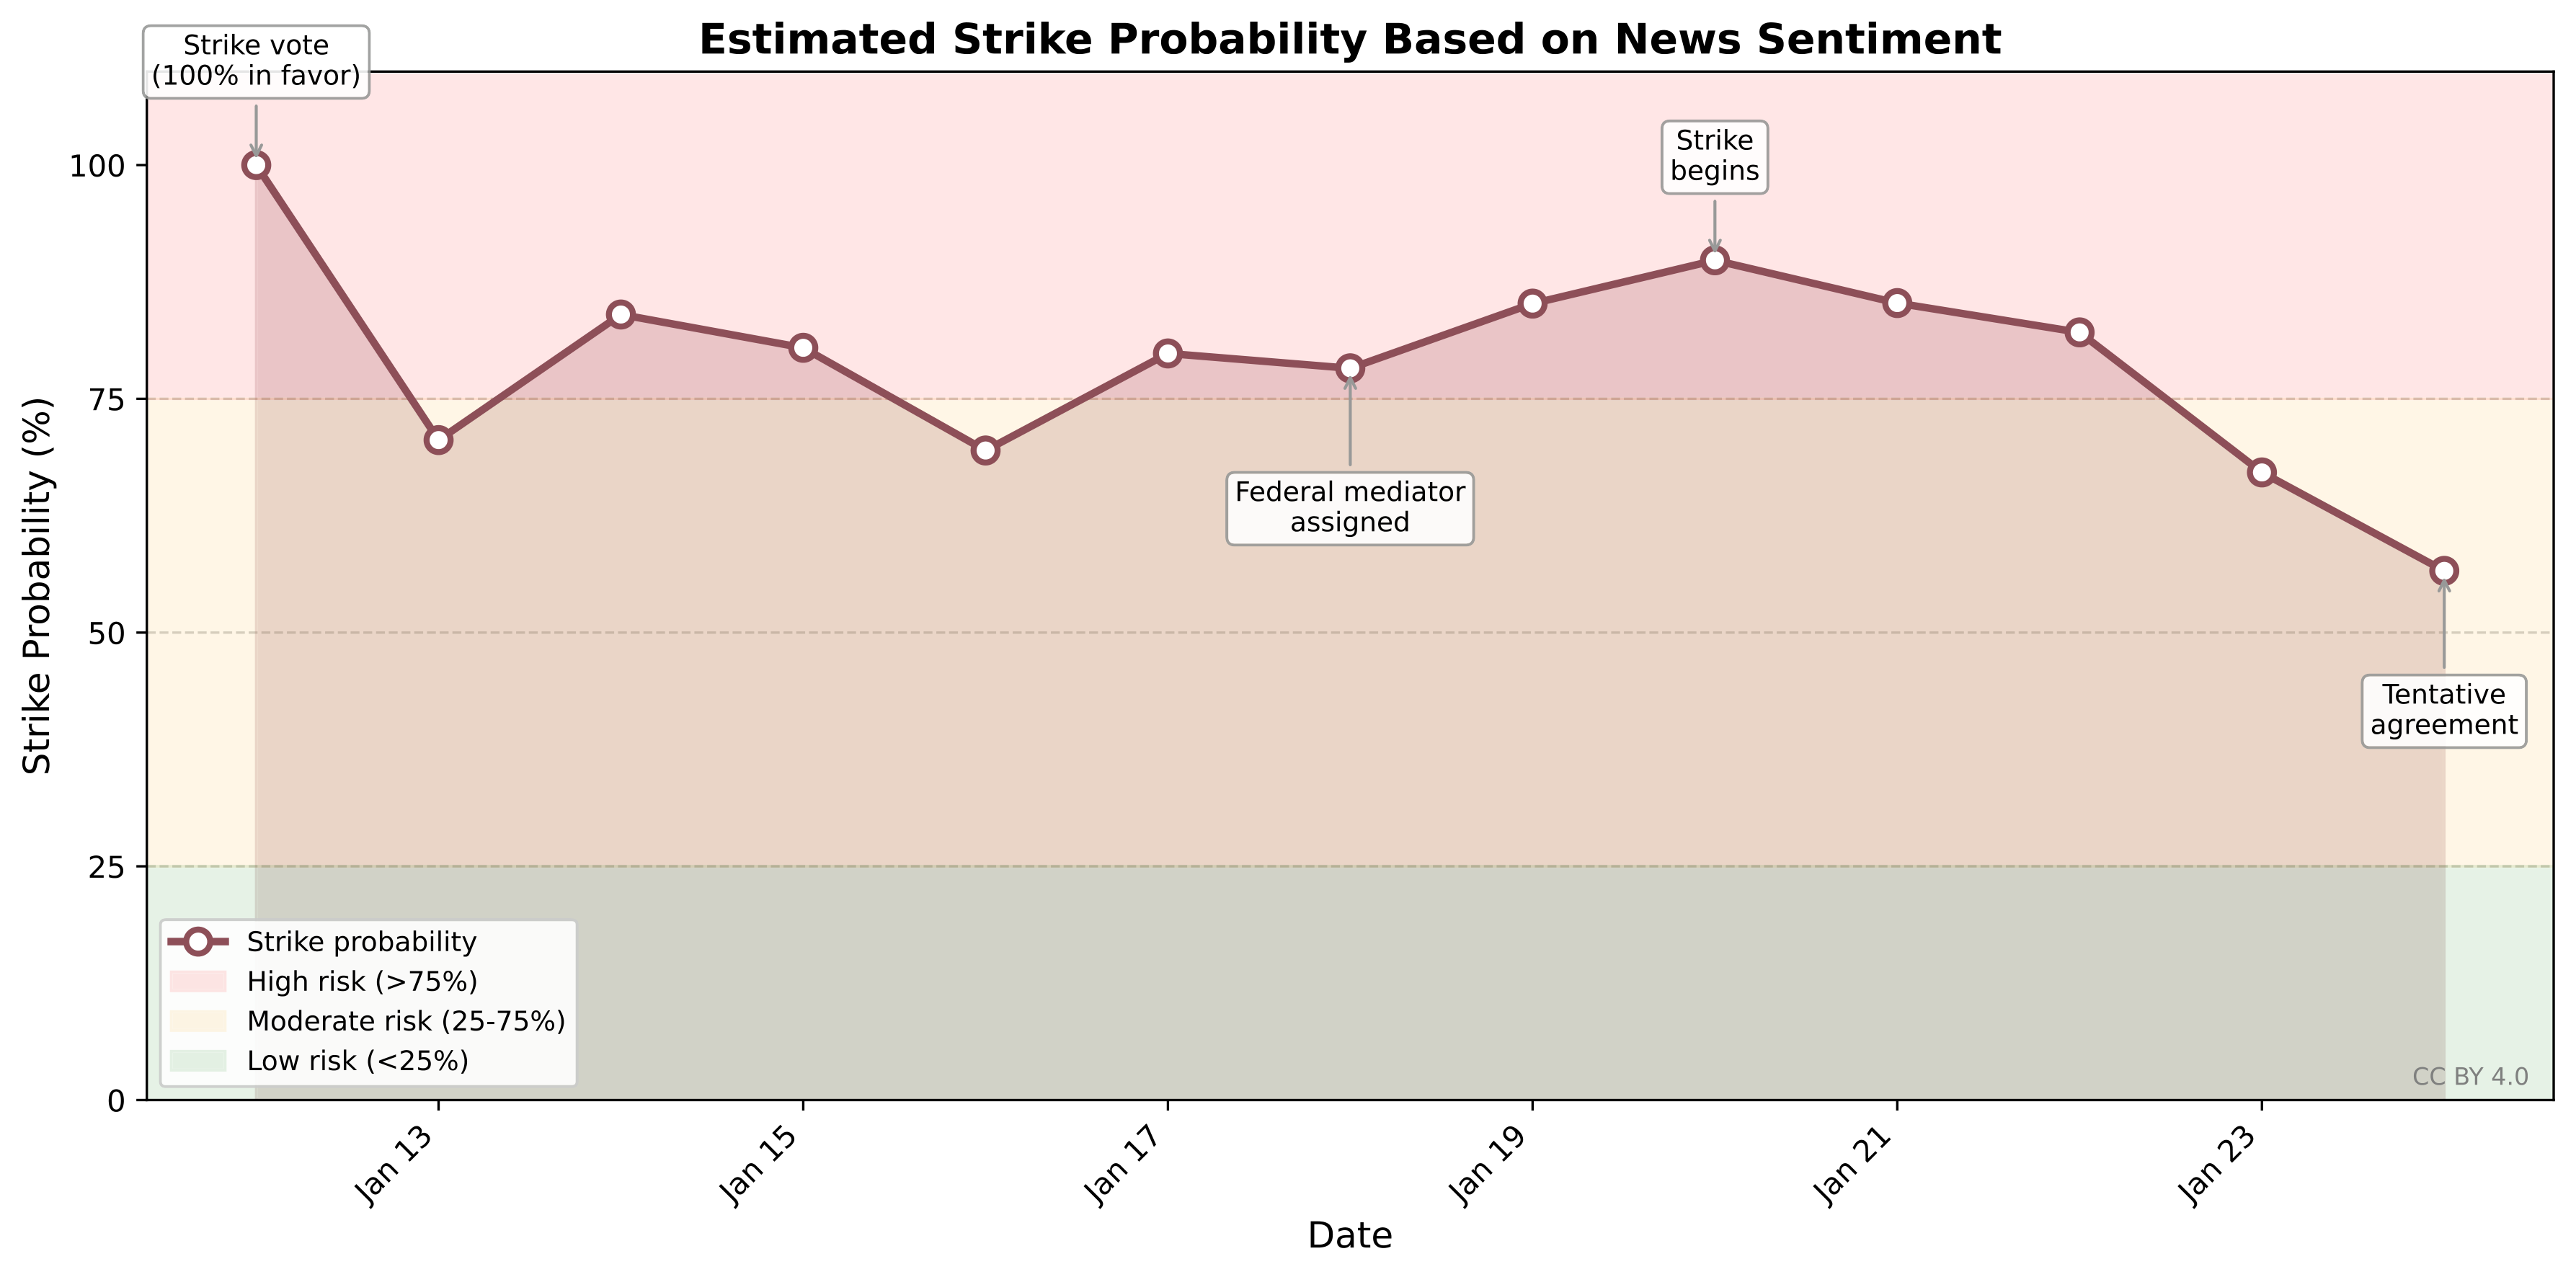

In [23]:
show_image(probability_chart_path, width=700)

**Figure:** Strike probability estimate over time based on weighted sentiment analysis. The chart shows probability starting at 100% when the unanimous strike vote was announced (Jan 12), remaining mostly in the high-risk zone (>75%) through the strike onset (Jan 20), then declining to moderate risk (~60%) after talks resumed and a tentative agreement was reached (Jan 24). Background colors indicate risk zones: red (high), orange (moderate), and green (low).

## Important Findings and Insights

This analysis reveals several patterns about how AI can interpret labor negotiation news:

In [24]:
# Calculate summary statistics by speaker type
def summarize_by_speaker(df):
    """Generate summary statistics grouped by speaker type."""
    summary = df.groupby('speaker_type').agg({
        'sentiment_score': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    summary.columns = ['Article Count', 'Mean Score', 'Std Dev', 'Min', 'Max']
    return summary

speaker_summary = summarize_by_speaker(df_results)
print("SENTIMENT ANALYSIS SUMMARY BY SPEAKER TYPE")
print(speaker_summary.to_string())
print()

# Calculate key metrics
avg_sentiment = df_results['sentiment_score'].mean()
final_probability = df_daily.iloc[-1]['strike_probability']
peak_probability = df_daily['strike_probability'].max()
min_probability = df_daily['strike_probability'].min()

print("KEY METRICS")
print(f"Average sentiment score:     {avg_sentiment:.2f} / 5.00")
print(f"Peak strike probability:     {peak_probability:.1f}% (Jan 12)")
print(f"Final strike probability:    {final_probability:.1f}% (Jan 24)")
print(f"Total change:                {peak_probability - final_probability:.1f} percentage points")

SENTIMENT ANALYSIS SUMMARY BY SPEAKER TYPE
              Article Count  Mean Score  Std Dev  Min  Max
speaker_type                                              
management                3        3.00     0.00    3    3
neutral                   8        2.12     0.99    1    4
union                     3        1.00     0.00    1    1

KEY METRICS
Average sentiment score:     2.07 / 5.00
Peak strike probability:     100.0% (Jan 12)
Final strike probability:    56.6% (Jan 24)
Total change:                43.4 percentage points


### Observations

1. **Speaker bias is predictable**: Union statements consistently scored 1 (very negative toward settlement), while management responses consistently scored 3 (neutral). The local LLM correctly identified that unions frame news as adversarial, while management tends toward measured responses.

2. **Neutral sources show variance**: Third-party news coverage ranged from 1 to 3, reflecting actual changes in the negotiation situation. This suggests neutral sources are most useful for tracking real progress.

3. **The model handled edge cases well**: Despite using a small 2.7B parameter model, the LLM successfully parsed article content, identified key signals, and produced consistent JSON output for all 14 articles.

4. **Probability estimates react to news**: The weighted average approach caused the probability to spike when the strike began (Jan 20) and drop when talks resumed (Jan 23-24). This behavior matches how human analysts would interpret these events.

### Limitations

This demo has several limitations to keep in mind:

- **Synthetic data**: The news articles are hypothetical and created for demonstration purposes. Real-world articles would have more nuance and complexity.
- **Small model bias**: The phi3:mini model (2.7B parameters) tends toward conservative scoring. Even positive developments like tentative agreements receive neutral scores (3) rather than positive scores (4-5). Larger models might capture more nuance.
- **Simple probability formula**: The linear mapping from sentiment to probability is a rough approximation. Real strike prediction would require more sophisticated modeling with multiple input factors.
- **No real-time capability**: This demo processes a static corpus. A production system would need web scraping, deduplication, and continuous monitoring.

## Conclusion

This notebook demonstrated a practical application of local AI for labor negotiation monitoring. Using a lightweight language model running entirely on a local machine, we analyzed synthetic news articles about the Porter Airlines flight dispatcher strike crisis and derived actionable insights.

**What We Built:**
- A sentiment analysis pipeline that extracts structured information from unstructured news text.
- A strike probability estimator using weighted sentiment scores.
- Visualizations that track negotiation progress over time.

**What We Learned:**
- Local LLMs can perform useful sentiment analysis without cloud services.
- Different stakeholders (union, management, media) frame the same events very differently.
- Time-weighted aggregation helps probability estimates react appropriately to new information.

**Practical Applications:**
This approach could be adapted for monitoring other high-stakes negotiations (mergers, trade deals, regulatory proceedings), tracking brand sentiment during crises, or building early-warning systems for operational disruptions. The main advantage of local inference is data privacy, which means sensitive business intelligence never leaves your machine.

## Cleanup

In [25]:
import gc

# Clean up variables used in this notebook
cleanup_vars = [
    # Phase 1 variables
    'available_models', 'inference_time', 'MODEL_NAME',
    # Phase 2 variables
    'DATA_PATH', 'corpus', 'df_articles', 'sample', 'f',
    # Phase 3 variables
    'SENTIMENT_PROMPT', 'test_article', 'test_result', 
    'analysis_results', 'df_results', 'df_daily',
    'column_order', 'date_str', 'row', 'signals',
    # Phase 4 variables
    'COLORS', 'SPEAKER_COLORS', 'KEY_EVENTS',
    'sentiment_timeline_path', 'probability_chart_path',
    'speaker_summary', 'avg_sentiment', 'final_probability',
    'peak_probability', 'min_probability'
]

for var in cleanup_vars:
    if var in dir():
        exec(f'del {var}')

gc.collect()
print("Memory cleaned up.")

Memory cleaned up.


## References

[1] Global News Canada, "Porter flight dispatchers issue strike action timeline," Dec. 11, 2025. [Online]. Available: https://globalnews.ca/news/11575952/porter-flight-dispatchers-strike-action-timeline/

[2] Travel Tourister, "Canada Airline Strike 2026: Porter January 20, WestJet, Air Canada Labor Crisis," Jan. 11, 2026. [Online]. Available: https://www.traveltourister.com/news/canada-airline-strike-2026-porter-january-20-westjet-air-canada-labor-crisis/

[3] A. Vaswani et al., "Attention Is All You Need," in Advances in Neural Information Processing Systems (NeurIPS), vol. 30, 2017.